In [1]:
!nvidia-smi

Sun Jul 21 12:50:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P0             27W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import string
from string import punctuation
import json
import os 
import pickle, joblib
import re 
from wordcloud import WordCloud

#
from sklearn.model_selection import train_test_split

# Importing tensorflow libraries
import tensorflow as tf 


# Importing nltk libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, ne_chunk

# Importing transformers libraries
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, pipeline, set_seed
from transformers import DataCollatorForSeq2Seq
from transformers import Seq2SeqTrainer
from transformers import Seq2SeqTrainingArguments
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments, pipeline


from torch.utils.data import DataLoader
import torch

#
import datasets
from datasets import load_metric, Dataset, DatasetDict
from datasets import DatasetDict

# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')

2024-07-21 12:51:53.094651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-21 12:51:53.094768: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-21 12:51:53.219246: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Downloading 'punkt', 'wordnet', and 'stopwords' from NLTK
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')

In [3]:
# Set Kaggle API token
os.environ['KAGGLE_USERNAME'] = 'mohamedshuhaib'
os.environ['KAGGLE_KEY'] = '4b49e94032e705ccf4de3cc91c0461fd'

In [4]:
paths = '/kaggle/input/d/pariza/bbc-news-summary/BBC News Summary'
paths = os.listdir(paths)
paths

['Summaries', 'News Articles']

In [5]:
articles_path = '/kaggle/input/d/pariza/bbc-news-summary/BBC News Summary/News Articles'
summaries_path = '/kaggle/input/d/pariza/bbc-news-summary/BBC News Summary/Summaries'


os.listdir(articles_path)

['politics', 'sport', 'tech', 'entertainment', 'business']

In [8]:

def load_data(file_dir):

    # Check if the base directory exists
    if not os.path.exists(file_dir):
        print(f"Base directory '{file_dir}' does not exist. Please check the path.")
    else:
        # Initialize lists to hold data
        categories = []
        contents = []
        file_name = []

        # Traverse the directory structure
        for root, dirs, files in os.walk(file_dir):
            for file in files:
                if file.endswith(".txt"):
                    category = os.path.basename(root)
                    file_path = os.path.join(root, file)

                    # Read file content
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        content = f.read()

                    categories.append(category)
                    contents.append(content)
                    file_name.append(file)

        # Create a DataFrame
        data = pd.DataFrame({
            'Category': categories,
            'Content': contents,
            'file_name': file_name
        })
        
    return data

In [9]:
# Define 
file_path_articles = "/kaggle/input/d/pariza/bbc-news-summary/BBC News Summary/News Articles"
file_path_summary = "/kaggle/input/d/pariza/bbc-news-summary/BBC News Summary/Summaries"

article_data = load_data(file_path_articles)
summary_data = load_data(file_path_summary)

In [10]:
summary_data.rename(columns={'Content': 'summary'}, inplace=True)
article_data.rename(columns={'Content': 'article'}, inplace=True)

In [11]:
data = pd.concat([article_data, summary_data], axis=1)

In [12]:
data.sample(5)

,Category,article,file_name,Category,summary,file_name
1300,tech,Fast moving phone bugs appear\n\nSecurity firm...,116.txt,tech,The new strains of the Cabir mobile phone viru...,116.txt
1063,tech,Broadband set to revolutionise TV\n\nBT is sta...,349.txt,tech,"With a broadband net subscription, you can als...",349.txt
307,politics,Student 'fee factor' played down\n\nA rise has...,047.txt,politics,"In June last year, Mr Wallace announced propos...",047.txt
1967,business,Italy to get economic action plan\n\nItalian P...,052.txt,business,The government says that it has set about tack...,052.txt
1146,tech,Mobile games come of age\n\nThe BBC News websi...,095.txt,tech,Even before Nokia's N-Gage game phone launched...,095.txt


In [13]:
df = data[['article', 'summary']]

In [14]:
df.head()

,article,summary
0,Budget to set scene for election\n\nGordon Bro...,- Increase in the stamp duty threshold from £6...
1,Army chiefs in regiments decision\n\nMilitary ...,"""They are very much not for the good and will ..."
2,Howard denies split over ID cards\n\nMichael H...,Michael Howard has denied his shadow cabinet w...
3,Observers to monitor UK election\n\nMinisters ...,The report said individual registration should...
4,Kilroy names election seat target\n\nEx-chat s...,"UKIP's leader, Roger Knapman, has said he is g..."


In [15]:

df.isnull().sum()

article    0
summary    0
dtype: int64

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   article  2225 non-null   object
 1   summary  2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [17]:
# 

df['article'] = df['article'].str.replace('\n\n', ' ').replace('\n', ' ')
df['summary'] = df['summary'].str.replace('\n\n', ' ').replace('\n', ' ')

df['article'] = df['article'] = df['article'].str.replace("'", '').str.replace('-', '')
df['summary'] = df['summary'] = df['summary'].str.replace("'", '').str.replace('-', '')

In [18]:
class TextPreprocessor:
  def __init__(self):
    self.contractions = {
            "i'll": "i will",
            "ill": "i will",
            "can't": "can not",
            "cant": "can not",
            "cannot": "can not",
            "won't": "will not",
            "wont": "will not",
            "n't": " not",
            "i'm": "i am",
            "im": "i am",
            "it's": "it is",
            "let's": "let us",
            "lets": "let us",
            "you're": "you are",
            "youre": "you are",
            "they're": "they are",
            "we're": "we are",
            "i've": "i have",
            "ive": "i have",
            "you've": "you have",
            "they've": "they have",
            "we've": "we have",
            "i'd": "i would",
            "id": "i would",
            "you'd": "you would",
            "they'd": "they would",
            "we'd": "we would",
            "he'd": "he would",
            "she'd": "she would",
            "it'd": "it would",
            "let's": "let us",
            "'ll": "will",
            "'re": "are",
            "'ve": "have",
            "'d": "would",
            "wanna": "want to",
            "didnt": "did not",
            "dont": "do not",
            "don't": "do not",
            "doesnot": "does not",
            "doesn't": "does not",
            "doesnt": "does not"
        }

  def replace_contractions(self, text):
    for contraction, full_form in self.contractions.items():
      text = re.sub(r'\b{}\b'.format(re.escape(contraction)), full_form, text)
    return text

  def preprocess(self, text):
    text = self.replace_contractions(text)
    return text

In [19]:
# Creating an instance of TextPreprocessor class

preprocessor = TextPreprocessor()

# Applying the preprocess method of TextPreprocessor to each text in the 'title' column of DataFrame df
processed_articles = df['article'].apply(preprocessor.preprocess)
processed_summary = df['summary'].apply(preprocessor.preprocess)

In [20]:
df['cleaned_article'] = processed_articles
df['cleaned_summary'] = processed_summary

In [96]:
df.head()

,article,summary,cleaned_article,cleaned_summary
0,Budget to set scene for election Gordon Brown ...,Increase in the stamp duty threshold from £60...,Budget to set scene for election Gordon Brown ...,Increase in the stamp duty threshold from £60...
1,Army chiefs in regiments decision Military chi...,"""They are very much not for the good and will ...",Army chiefs in regiments decision Military chi...,"""They are very much not for the good and will ..."
2,Howard denies split over ID cards Michael Howa...,Michael Howard has denied his shadow cabinet w...,Howard denies split over ID cards Michael Howa...,Michael Howard has denied his shadow cabinet w...
3,Observers to monitor UK election Ministers wil...,The report said individual registration should...,Observers to monitor UK election Ministers wil...,The report said individual registration should...
4,Kilroy names election seat target Exchat show ...,"UKIPs leader, Roger Knapman, has said he is gl...",Kilroy names election seat target Exchat show ...,"UKIPs leader, Roger Knapman, has said he is gl..."


In [24]:
# Crafting a function to count the words in each instance

def word_count(sentence):
    sentences = sentence.split()
    return len(sentences)

In [27]:
df['num_words_article'] = df['cleaned_article'].apply(word_count)
df['num_words_summary'] = df['cleaned_summary'].apply(word_count)

# Character count
# df['article'].apply(len)

In [28]:
# Display statistical info about the word length

df.describe()

,num_words_article,num_words_summary
count,2225.000000,2225.000000
mean,383.121798,164.650337
std,237.700820,108.322062
min,89.000000,38.000000
25%,245.000000,103.000000
50%,331.000000,142.000000
75%,470.000000,202.000000
max,4434.000000,2073.000000


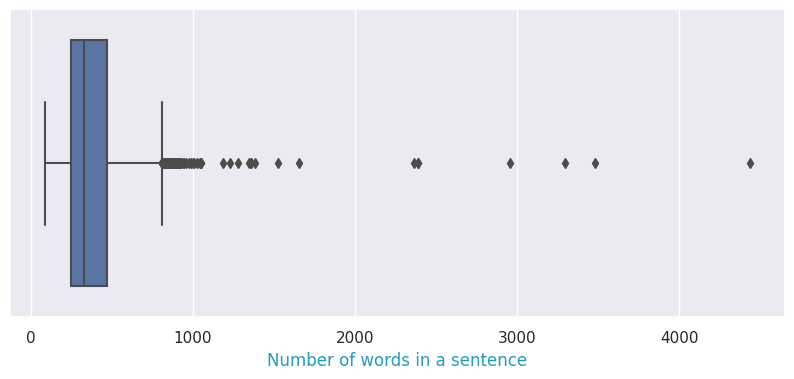

In [29]:

sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 4))

sns.boxplot(x=df['num_words_article'])
plt.xlabel('Number of words in a sentence', fontdict={'color': '#219ebc'})
plt.show()

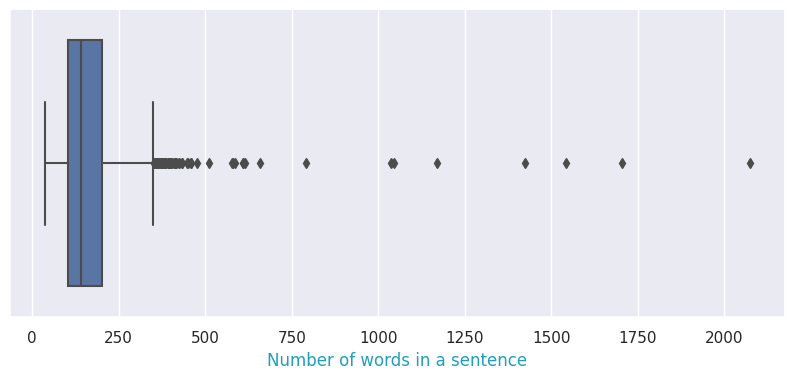

In [30]:

sns.set_theme(style='darkgrid')
plt.figure(figsize=(10, 4))

sns.boxplot(x=df['num_words_summary'])
plt.xlabel('Number of words in a sentence', fontdict={'color': '#219ebc'})
plt.show()

In [31]:
# Calculating IQR 
def calculate_iqr(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)

    IQR = Q3 - Q1

    # Define the upper and lower bound

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Print the calculated values
    print(f"For column: {col}\n")
    print(f'Q1: {Q1}')
    print(f'Q3: {Q3}')
    print(f'IQR: {IQR}')
    print(f'Lower Bound: {lower_bound}')
    print(f'Upper Bound: {upper_bound}\n')

In [32]:
calculate_iqr('num_words_article')

calculate_iqr('num_words_summary')

For column: num_words_article

Q1: 245.0
Q3: 470.0
IQR: 225.0
Lower Bound: -92.5
Upper Bound: 807.5

For column: num_words_summary

Q1: 103.0
Q3: 202.0
IQR: 99.0
Lower Bound: -45.5
Upper Bound: 350.5



In [33]:
article_upper = 808
summary_upper = 350

In [34]:
# Removing the outliers

num_outliers = df[(df['num_words_article'] > article_upper) & (df['num_words_summary'] > summary_upper)]
num_outliers.shape[0]

50

In [35]:
# Removing the outliers

ndf = df[(df['num_words_article'] <= 808) & (df['num_words_summary'] <= 350)]

In [36]:
ndf.head()

,article,summary,cleaned_article,cleaned_summary,num_words_article,num_words_summary
0,Budget to set scene for election Gordon Brown ...,Increase in the stamp duty threshold from £60...,Budget to set scene for election Gordon Brown ...,Increase in the stamp duty threshold from £60...,533,187
1,Army chiefs in regiments decision Military chi...,"""They are very much not for the good and will ...",Army chiefs in regiments decision Military chi...,"""They are very much not for the good and will ...",499,265
2,Howard denies split over ID cards Michael Howa...,Michael Howard has denied his shadow cabinet w...,Howard denies split over ID cards Michael Howa...,Michael Howard has denied his shadow cabinet w...,541,225
3,Observers to monitor UK election Ministers wil...,The report said individual registration should...,Observers to monitor UK election Ministers wil...,The report said individual registration should...,495,223
4,Kilroy names election seat target Exchat show ...,"UKIPs leader, Roger Knapman, has said he is gl...",Kilroy names election seat target Exchat show ...,"UKIPs leader, Roger Knapman, has said he is gl...",439,184


In [37]:
ndf.shape

(2146, 6)

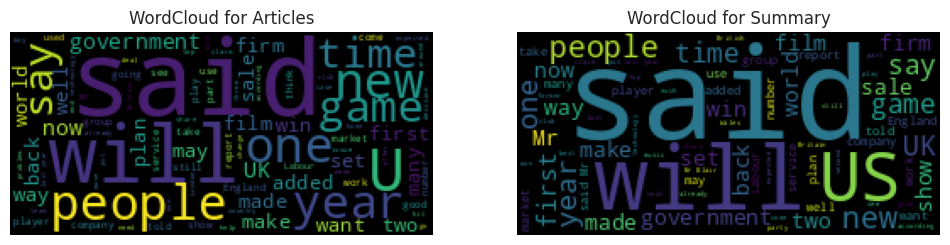

In [51]:
plt.figure(figsize=(12, 6))

# Generate and plot WordCloud for articles
plt.subplot(1, 2, 1)
dt = " ".join(ndf['cleaned_article'].tolist())

wc = WordCloud(width=250, height=120).generate(dt)
plt.title(f"WordCloud for Articles")
plt.imshow(wc)
plt.axis('off')

# Generate and plot WordCloud for summaries
dt1 = " ".join(ndf['cleaned_summary'].tolist())
plt.subplot(1, 2, 2)
wc2 = WordCloud(width=250, height=120).generate(dt1)
plt.title(f"WordCloud for Summary")
plt.imshow(wc2)

# Adjust layout and show the plots
plt.axis('off')
plt.show()

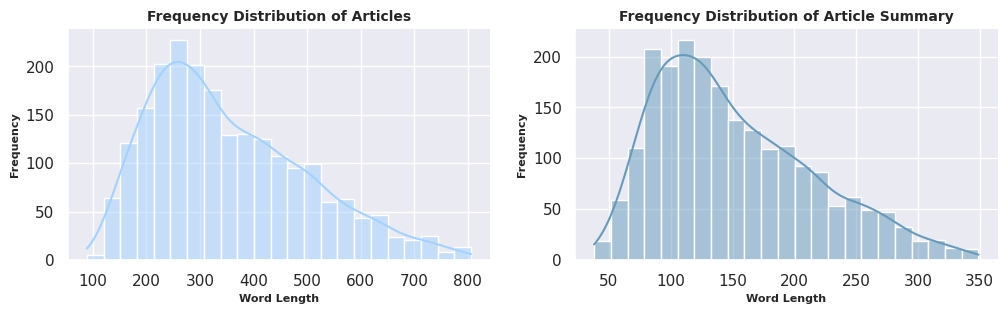

In [55]:
# Frequency Distribution of text length 

# Set up the plot
sns.set_theme(style='darkgrid')
plt.figure(figsize=(12, 3))

# Plot histogram for Authentic News
plt.subplot(1, 2, 1)
sns.histplot(x=ndf['num_words_article'], color='#a2d2ff', kde=True)
plt.title('Frequency Distribution of Articles', fontdict={'weight': 'bold', 'fontsize': 10})
plt.xlabel('Word Length', fontdict={'weight': 'bold', 'fontsize': 8})
plt.ylabel('Frequency', fontdict={'weight': 'bold', 'fontsize': 8})

# Plot histogram for Fake News
plt.subplot(1, 2, 2)
sns.histplot(x=ndf['num_words_summary'], color='#669bbc', kde=True)
plt.title('Frequency Distribution of Article Summary', fontdict={'weight': 'bold', 'fontsize': 10})
plt.xlabel('Word Length', fontdict={'weight': 'bold', 'fontsize': 8})
plt.ylabel('Frequency', fontdict={'weight': 'bold', 'fontsize': 8})

sns.despine()
plt.show()

In [56]:
ndf = ndf[['cleaned_article', 'cleaned_summary']]

In [57]:
# Splitting the data into training and testing

train_df, test_df = train_test_split(ndf, test_size=0.3, random_state=42)

In [58]:
# Printing the shapes of the training and testing sets

print(train_df.shape)
print(test_df.shape)


(1502, 2)
(644, 2)


In [59]:
# Convert the Dataframe into DatasetDict

train_dataset = Dataset.from_dict(train_df)
test_dataset = Dataset.from_dict(test_df)

dataset = datasets.DatasetDict({"train": train_dataset, "test": test_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['cleaned_article', 'cleaned_summary'],
        num_rows: 1502
    })
    test: Dataset({
        features: ['cleaned_article', 'cleaned_summary'],
        num_rows: 644
    })
})

In [62]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [61]:

tokenizer = AutoTokenizer.from_pretrained('facebook/bart-base')

trainer_model = AutoModelForSeq2SeqLM.from_pretrained('facebook/bart-base').to(device)

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [63]:
max_len_article = int(article_upper)
max_len_summary = int(summary_upper)

In [64]:
def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["cleaned_article"],
        max_length=max_len_article,
        truncation=True,
        padding='max_length'
    )
    labels = tokenizer(
        examples["cleaned_summary"], 
        max_length=max_len_summary, 
        truncation=True,
        padding='max_length'
    )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [65]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/1502 [00:00<?, ? examples/s]

Map:   0%|          | 0/644 [00:00<?, ? examples/s]

In [66]:
print(tokenized_datasets)

DatasetDict({
    train: Dataset({
        features: ['cleaned_article', 'cleaned_summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1502
    })
    test: Dataset({
        features: ['cleaned_article', 'cleaned_summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 644
    })
})


**ROUGE**

*ROUGE, or Recall-Oriented Understudy for Gissting Evaluatoin, is a set of metrics and a software package used for evaluating automatic summariztion and machine translation software in NLP. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation. Note that ROUGE is case insensitive, meaning that upper case letters are treated the same way as lower case letters.*

*Inputs * predictions (list): list of predictions to score. Each prediction should be a string with tokens separated by spaces. * references (list or list[list]): list of reference for each prediction or a list of several references per prediction. Each reference should be a string with tokens separated by spaces. * rouge_types (list): A list of rouge types to calculate. Defaults to ['rouge1', 'rouge2', 'rougeL', 'rougeLsum']. Valid rouge types: "rouge1": unigram (1-gram) based scoring "rouge2": bigram (2-gram) based scoring "rougeL": Longest common subsequence based scoring. "rougeLSum": splits text using "\n"*


*Output Values
The output is a dictionary with one entry for each rouge type in the input list rouge_types.*

In [72]:
!pip install evaluate
!pip install rouge_score

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.9 MB/s eta 0:00:00a 0:00:01


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=f7f5732ece9a5bb94ba5d30d618e0439ccde5b16bc1038b7dd87b64ccc26225f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [77]:
import evaluate

rouge_score = evaluate.load("rouge")

In [78]:
# Example on using rouge

reference_summary = "The crypto rally resumed on Friday with bitcoin (BTC) notching its highest price in a month, while the world grappled with a major IT outageBTC started rising from $64,000 during the early U.S. trading hours and broke above $67,000 later in the day for the first time since June 17. The price increase was accompanied by strong trading volumes for BlackRock's spot bitcoin ETF (IBIT). At press time, the largest crypto asset changed hands slightly above $67,000 advancing 5.5% over the past 24 hours."

generated_summary = "Bitcoin surged to a one-month high above $67,000 on Friday, fueled by strong trading activity for BlackRock's new spot Bitcoin ETF, IBIT. This marks the first time Bitcoin reached this price point since mid-June, amidst a broader global IT outage."

scores = rouge_score.compute(predictions=[generated_summary], references=[reference_summary])

scores

{'rouge1': 0.38805970149253727,
 'rouge2': 0.18181818181818182,
 'rougeL': 0.2537313432835821,
 'rougeLsum': 0.2537313432835821}

**Generating Summaries using Pipeline**

In [79]:
summarizer = pipeline("summarization", model=trainer_model, tokenizer=tokenizer, device=device)

In [80]:
summarizer

In [81]:

def print_summary(idx, max_len, min_len):
    article = dataset['test']['cleaned_article'][idx]
    summary = dataset['test']['cleaned_summary'][idx]
    
    generated_summary = summarizer(
                            article,
                            max_length=max_len,
                            min_length=min_len,
                            length_penalty=2.0)[0]['summary_text'] # E
    
    score = rouge_score.compute(predictions=[generated_summary], references=[summary])
    
    # Print summaries
    print(f"-- Article: {article}\n")
    print(f"--Summary: {summary}\n")
    print(f"--Generated Summary: {generated_summary}\n")
    print(f">> Rouge Score: {scores}")

*length_penalty ensure that the model doesnot generate sequences that is too long*

In [91]:
print_summary(5, 100, 20)

-- Article: Mobile gig aims to rock 3G Forget about going to a crowded bar to enjoy a gig by the latest darlings of the music press. Now you could also be at a live gig on your mobile, via the latest third generation (3G) video phones. Rock outfit Rooster are playing what has been billed as the first ever concert broadcast by phone on Tuesday evening from a London venue. The 45minute gig is due to be "phone cast" by the 3G mobile phone operator, 3. 3G technology let us people take, watch and send video clips on their phones, as well as swap data much faster than with 2G networks like GSM. People with 3G phones in the UK can already download football and music clips on their handsets. Some 1,000 fans of the Londonbased band will have to pay five pounds for a ticket and need a 3G handset. "Once you have paid, you can come and go as much as you like, because we expect the customers to be mobile," said 3 spokesperson Belinda Henderson. "Its like going to a concert hall, except that you are

**Fine-Tuning BART**

In [92]:
# Creating data_collator 
# A data_collator is a function that takes a batch of data and collates it into a format suitable for model training

data_collator = DataCollatorForSeq2Seq(tokenizer, model=trainer_model)


In [93]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['cleaned_article', 'cleaned_summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 1502
    })
    test: Dataset({
        features: ['cleaned_article', 'cleaned_summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 644
    })
})

In [94]:
tokenized_datasets = tokenized_datasets.remove_columns(dataset['train'].column_names)

In [95]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1502
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 644
    })
})

In [101]:
# Define training arguments

training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    gradient_accumulation_steps=8,
    fp16=True,
    eval_steps=10,
    logging_steps=10,
    predict_with_generate=True
)

In [102]:
# Initialize Trainer

trainer = Seq2SeqTrainer(
    model=trainer_model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer
)

In [103]:
torch.cuda.empty_cache()

In [104]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
0,1.810100,1.373616
2,0.839500,0.590165
4,0.360500,0.205931
6,0.153500,0.114594
8,0.106700,0.095762
10,0.093900,0.090268
12,0.090800,0.087671
14,0.087000,0.086792
16,0.082300,0.085838
18,0.077600,0.085734


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 12, 'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


TrainOutput(global_step=460, training_loss=0.34279203272384146, metrics={'train_runtime': 3164.4918, 'train_samples_per_second': 9.493, 'train_steps_per_second': 0.145, 'total_flos': 1.414589535830016e+16, 'train_loss': 0.34279203272384146, 'epoch': 19.574468085106382})

In [108]:
# Evaluate the model

# eval_results = trainer.evaluate()

print("Evaluation Results: ")
for key, value in eval_results.items():
    print(f"{key}: {value}")

Evaluation Results: 
eval_loss: 0.08570072054862976
eval_runtime: 20.8655
eval_samples_per_second: 30.864
eval_steps_per_second: 3.882
epoch: 19.574468085106382


********

In [134]:
# Load ROUGE metric
rouge_metric = load_metric('rouge')

def print_summary(model, tokenizer, device, idx, max_len, min_len):
    article = dataset['test']['cleaned_article'][idx]
    summary = dataset['test']['cleaned_summary'][idx]
    
    # Initialize summarizer pipeline
    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=device)
    
    # Generate summary
    generated_summary = summarizer(
        article,
        max_length=max_len,
        min_length=min_len,
        length_penalty=2.0,
        num_beams=4,
        no_repeat_ngram_size=3,
        early_stopping=True
    )[0]['summary_text']
    
    # Compute ROUGE score
    rouge_results = rouge_metric.compute(predictions=[generated_summary], references=[summary])
    
    # Print summaries and ROUGE scores
    print(f"-- Article: {article}\n")
    print(f"-- Summary: {summary}\n")
    print(f"-- Generated Summary: {generated_summary}\n")
#     print(f">> ROUGE Score: {rouge_results}\n")
    
    # Print ROUGE Scores
    print(f">> ROUGE Scores:")
    print(f"  ROUGE-1: Precision: {rouge_results['rouge1'].mid.precision:.4f}, Recall: {rouge_results['rouge1'].mid.recall:.4f}, F-measure: {rouge_results['rouge1'].mid.fmeasure:.4f}")
    print(f"  ROUGE-2: Precision: {rouge_results['rouge2'].mid.precision:.4f}, Recall: {rouge_results['rouge2'].mid.recall:.4f}, F-measure: {rouge_results['rouge2'].mid.fmeasure:.4f}")
    print(f"  ROUGE-L: Precision: {rouge_results['rougeL'].mid.precision:.4f}, Recall: {rouge_results['rougeL'].mid.recall:.4f}, F-measure: {rouge_results['rougeL'].mid.fmeasure:.4f}")
    print(f"  ROUGE-Lsum: Precision: {rouge_results['rougeLsum'].mid.precision:.4f}, Recall: {rouge_results['rougeLsum'].mid.recall:.4f}, F-measure: {rouge_results['rougeLsum'].mid.fmeasure:.4f}")



In [135]:
checkpoint_dir = '/kaggle/working/results/checkpoint-460'

# Load the tokenizer and model from the checkpoint directory
tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_dir)


print_summary(model=model, tokenizer=tokenizer, device=device, idx=5, max_len=116, min_len=20)

-- Article: Mobile gig aims to rock 3G Forget about going to a crowded bar to enjoy a gig by the latest darlings of the music press. Now you could also be at a live gig on your mobile, via the latest third generation (3G) video phones. Rock outfit Rooster are playing what has been billed as the first ever concert broadcast by phone on Tuesday evening from a London venue. The 45minute gig is due to be "phone cast" by the 3G mobile phone operator, 3. 3G technology let us people take, watch and send video clips on their phones, as well as swap data much faster than with 2G networks like GSM. People with 3G phones in the UK can already download football and music clips on their handsets. Some 1,000 fans of the Londonbased band will have to pay five pounds for a ticket and need a 3G handset. "Once you have paid, you can come and go as much as you like, because we expect the customers to be mobile," said 3 spokesperson Belinda Henderson. "Its like going to a concert hall, except that you are

In [139]:
checkpoint_dir = '/kaggle/working/results/checkpoint-460'

# Load the tokenizer and model from the checkpoint directory
tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_dir)


print_summary(model=model, tokenizer=tokenizer, device=device, idx=105, max_len=116, min_len=20)

-- Article: Labours Cunningham to stand down Veteran Labour MP and former Cabinet minister Jack Cunningham has said he will stand down at the next election. One of the few Blairera ministers to serve under Jim Callaghan, he was given the agriculture portfolio when Labour regained power in 1997. Mr Cunningham went on to become Tony Blairs "cabinet enforcer". He has represented the constituency now known as Copeland since 1970. Mr Blair said he was a "huge figure" in Labour and a "valued, personal friend". During Labours long period in opposition, Mr Cunningham held a number of shadow roles including foreign affairs, the environment and as trade spokesman. As agriculture minister he caused controversy when he decided to ban beef on the bone in the wake of fears over BSE. He quit the government in 1999 and in recent years has served as the chairman of the allparty committee on Lords reform and has been a loyal supporter of the government from the backbenches.


-- Summary: Veteran Labour 

In [141]:
checkpoint_dir = '/kaggle/working/results/checkpoint-460'

# Load the tokenizer and model from the checkpoint directory
tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_dir)


print_summary(model=model, tokenizer=tokenizer, device=device, idx=477, max_len=116, min_len=20)

-- Article: Intel unveils laser breakthrough Intel has said it has found a way to put a siliconbased laser on a chip, raising hopes of much faster networks. Scientists at Intel have overcome a fundamental problem that before now has prevented silicon being used to generate and amplify laser light. The breakthrough should make it easier to interconnect data networks with the chips that process the information. The Intel researchers said products exploiting the breakthrough should appear by the end of the decade. "Weve overcome a fundamental limit," said Dr Mario Paniccia, director of Intels photonics technology lab. Writing in the journal Nature, Dr Paniccia  and colleagues Haisheng Rong, Richard Jones, Ansheng Liu, Oded Cohen, Dani Hak and Alexander Fang  show how they have made a continuous laser from the same material used to make computer processors. Currently, says Dr Paniccia, telecommunications equipment that amplifies the laser light that travels down fibre optic cables is very 

In [148]:
checkpoint_dir = '/kaggle/working/results/checkpoint-460'

# Load the tokenizer and model from the checkpoint directory
tokenizer = AutoTokenizer.from_pretrained(checkpoint_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(checkpoint_dir)


print_summary(model=model, tokenizer=tokenizer, device=device, idx=575, max_len=107, min_len=20)

-- Article: US cyber security chief resigns The man making sure US computer networks are safe and secure has resigned after only a year in his post. Amit Yoran was director of the National Cyber Security Division within the US Department of Homeland Security created following the 9/11 attacks. The division was tasked with improving US defences against malicious hackers, viruses and other netbased threats. Reports suggest he left because his division was not given enough clout within the larger organisation. Mr Yoran took up his post in September 2003 and his first task was to get the Cyber Security Division up and running. The organisation had a staff of about 60 people and a budget of about $80m (£44.54m). The division was charged with thinking up and carrying out action to make US networks more impervious to attack and disruption by the viruses, worms and hack attacks that have become commonplace. In the last 12 months Mr Yoran oversaw the creation of a cyber alert system that sends 

In [149]:
# Save the trained Model

model_path = '/kaggle/working/results/bart_final_model'
tokenizer_path = '/kaggle/working/results/final_tokenizer'

trainer.save_model(model_path)
tokenizer.save_pretrained(tokenizer_path)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 12, 'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('/kaggle/working/results/final_tokenizer/tokenizer_config.json',
 '/kaggle/working/results/final_tokenizer/special_tokens_map.json',
 '/kaggle/working/results/final_tokenizer/vocab.json',
 '/kaggle/working/results/final_tokenizer/merges.txt',
 '/kaggle/working/results/final_tokenizer/added_tokens.json',
 '/kaggle/working/results/final_tokenizer/tokenizer.json')

In [158]:
# Load the model and tokenizer 

loaded_tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
loaded_model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

print_summary(model=loaded_model, tokenizer=loaded_tokenizer, device=device, idx=287, max_len=189, min_len=20)

-- Article: Google launches TV search service The net search giant Google has launched a search service that let us people look for TV programmes. The service, Google Video beta, searches closed caption information that comes with programmes. It only searches US channel content currently. Results list programmes with still images and text from the point where the search phrase was spoken. It should expand over time to include content from more channels, said a Google spokesperson. The first version of the service is part of Googles expanding efforts to be a ubiquitous search engine for people to find what they want on the web and beyond. "We think TV is a big part of peoples lives," said Jonathan Rosenberg, Googles vice president of product management. "Ultimately, we would like to have all TV programming indexed." Google Video has been indexing USbased programmes from PBS, the NBA, Fox News, and CSPAN since December. But there were few clues from Google about when more global broadcas

In [165]:
dir_path = '/kaggle/working/results/final_tokenizer'
dir_path_model = '/kaggle/working/results/bart_final_model'

dir_path_checkpoint = '/kaggle/working/results/checkpoint-460'

# shutil.make_archive('/kaggle/working/final_tokenizer', 'zip', dir_path)
# shutil.make_archive('/kaggle/working/bart_final_model', 'zip', dir_path_model)

shutil.make_archive('/kaggle/working/results/checkpoint-460', 'zip', dir_path_checkpoint)

'/kaggle/working/results/checkpoint-460.zip'